## End-to-End Hybrid Knowledge Graph Pipeline

This notebook implements **a working, end-to-end pipeline on real data**:

1. **Load real radiology reports** from a public Hugging Face dataset  
   (e.g., `itsanmolgupta/mimic-cxr-dataset`).

2. **Extract entities and relations** using an **actual model**  
   (RadGraph-style DYGIE++ inference).

3. **Constrain the schema** to:
   - **Entity types:** `ANATOMY`, `OBSERVATION`  
     *(measurement entities excluded from ontology grounding)*
   - **Relation types:** all RadGraph-predicted relations  
     (e.g., `LOCATED_AT`, `MODIFY`)

4. **Map extracted mentions to UMLS CUIs** using a  
   **deterministic MRCONSO-based exact-matching pipeline**  
   *(no fuzzy matching or confidence thresholds)*.

5. **Build a Hybrid Knowledge Graph**:
   - **`V_prior`:** ontology-anchored concept nodes via UMLS CUIs  
     *(semantic reference space)*
   - **`V_data`:** instance nodes from extracted findings connected by RadGraph relations

6. **Export Phase I artifacts**  
   (entity–CUI mappings and graph structures) for downstream training.


In [1]:
# Suppress DeprecationWarning from jupyter_client and related libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="_distutils_hack")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="radgraph")

import os, re, json
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional


## 1) Load a real radiology report dataset

We'll use a public dataset on Hugging Face.

Default: `X-iZhang/MIMIC-CXR-RRG`



In [2]:
import os
from huggingface_hub import snapshot_download

def download_subset(
    repo_id: str,
    save_dir: str,
    patterns: list[str],
    repo_type: str = "dataset",
):
    """
    Download only the files matching `patterns` from a HF dataset repo.

    """
    os.makedirs(save_dir, exist_ok=True)

    local_path = snapshot_download(
        repo_id=repo_id,
        repo_type=repo_type,
        local_dir=save_dir,
        local_dir_use_symlinks=False,
        allow_patterns=patterns,   # key: only download what matches these
    )
    print(f"Downloaded to: {local_path}")

if __name__ == "__main__":
    REPO = "X-iZhang/MIMIC-CXR-RRG"
    OUT  = "MIMIC-CXR-RRG_small"   # <-- change this

    # ---- Choose ONE of these pattern sets ----

    # A) Only findings_section folder (~7.52 GB)
    # patterns = ["findings_section/*", "README.md", ".gitattributes"]

    # B) Only impression_section folder (~7.5 GB-ish)
    # patterns = ["impression_section/*", "README.md", ".gitattributes"]

    # C) Only 1 shard from findings_section (~471 MB)
    # patterns = ["findings_section/test-00000-of-00016.parquet", "README.md"]

    # D) First 2 shards from impression_section and 1 from findings (~< 1 GB)
    patterns = [
        "findings_section/test-00000-of-00016.parquet",
        "impression_section/test-00000-of-00016.parquet",
        "impression_section/test-00001-of-00016.parquet",
        "README.md"
    ]

    download_subset(REPO, OUT, patterns)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

impression_section/test-00000-of-00016.p(…):   0%|          | 0.00/457M [00:00<?, ?B/s]

findings_section/test-00000-of-00016.par(…):   0%|          | 0.00/471M [00:00<?, ?B/s]

impression_section/test-00001-of-00016.p(…):   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloaded to: /content/MIMIC-CXR-RRG_small


In [4]:
from datasets import load_dataset

# Load a specific subset (e.g., findings_section)
ds_findings = load_dataset(OUT, name="findings_section", split="test", verification_mode="no_checks")

ds_impressions = load_dataset(OUT, name="impression_section", split="test", verification_mode="no_checks")

# View sample
print(ds_findings[0]["findings_section"])


Heart size is borderline enlarged but unchanged. Mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Hyperinflation of the lungs with bullous emphysematous changes are again noted in the upper lobes. Lungs are clear without focal consolidation. No pleural effusion or pneumothorax is present. Pulmonary vasculature is normal. Right-sided rib cage deformities are chronic. Partially visualized is cervical spinal fusion hardware.


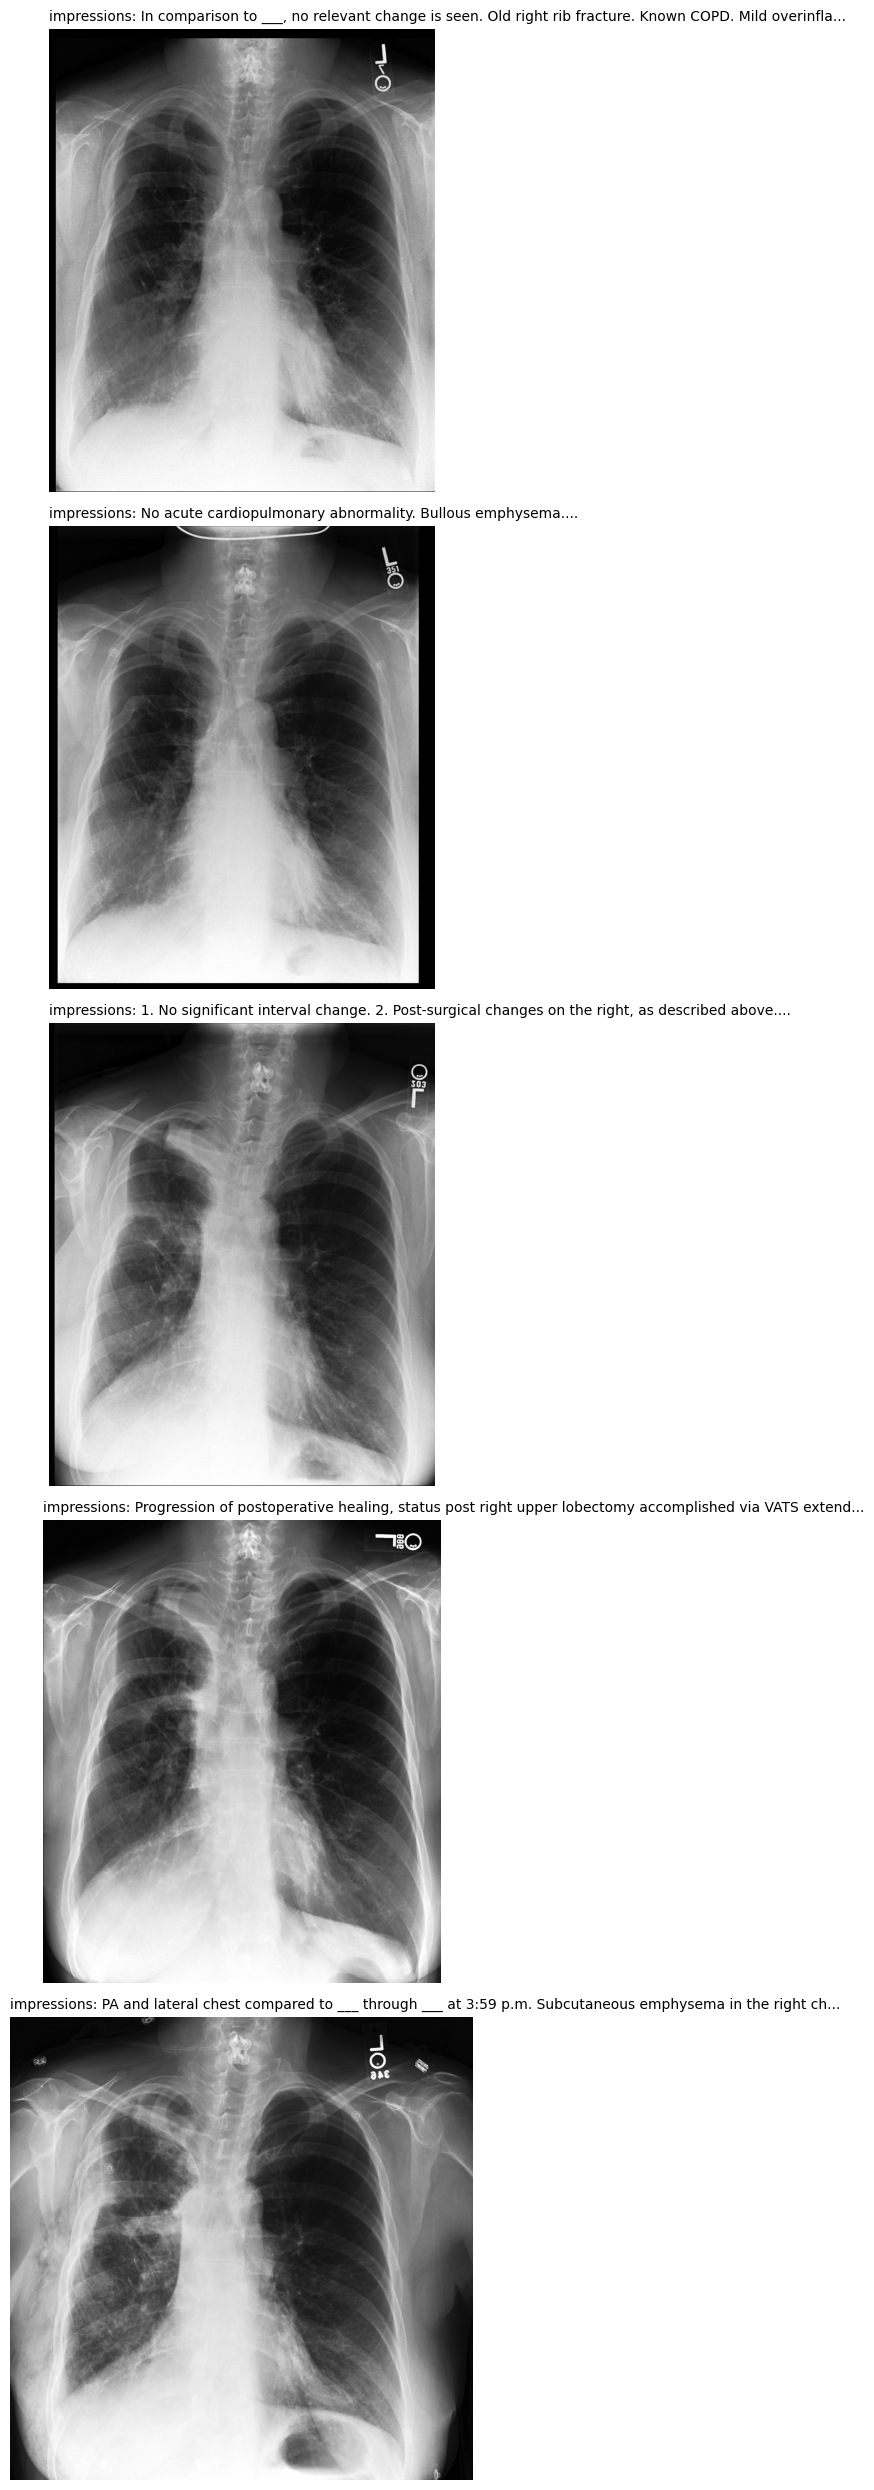

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images_and_impressions(dataset, num_images=5):
    plt.figure(figsize=(15, 5 * num_images)) # Adjust figure size for vertical layout
    for i in range(min(num_images, len(dataset))):
        image = dataset[i]["main_image"]
        impressions = dataset[i]["impression_section"]

        ax = plt.subplot(num_images, 1, i + 1)
        ax.imshow(image, cmap='gray') # Assuming images are grayscale; adjust if RGB
        ax.set_title(f"impressions: {impressions[:100]}...", fontsize=10, loc='left', wrap=True) # Truncate long impressions
        ax.axis('off') # Hide axes
    plt.tight_layout()
    plt.show()

# Call the function with ds_impressions (assuming it's already loaded)
display_images_and_impressions(ds_impressions, num_images=5)

In [5]:
import pandas as pd

# Convert ds_findings to a pandas DataFrame
df_findings = ds_findings.to_pandas()

# Convert ds_impressions to a pandas DataFrame
df_impressions = ds_impressions.to_pandas()




In [ ]:
print("Exploring ds_findings (DataFrame):")
print("Head:")
df_findings.head()

In [ ]:
print("\nInfo:")
df_findings.info()


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   dicom_id                                    154 non-null    object
 1   study_id                                    154 non-null    object
 2   subject_id                                  154 non-null    object
 3   main_image                                  154 non-null    object
 4   findings_section                            154 non-null    object
 5   impression_section                          114 non-null    object
 6   indication_section                          87 non-null     object
 7   comparison_section                          66 non-null     object
 8   technique_section                           58 non-null     object
 9   history_section                             59 non-null     object
 10  examination_section

In [ ]:
print("\n\nExploring ds_impressions (DataFrame):")
print("Head:")
df_impressions.head()




Exploring ds_impressions (DataFrame):
Head:


dicom_id  study_id subject_id  \
0  7558ad38-de530501-5c2ff2a1-d74fe121-ba0cf77a  56587463   19991135   
1  1b02ffa5-a6da06e3-9063b9ef-5e540245-c18323b5  54742755   19991135   
2  7cdd0c6e-d0263417-262f1fce-bd3d2712-99409e00  51777681   19991135   
3  a8c08cbf-15ac0dac-b76a40a0-dab826c7-18015767  50286241   19991135   
4  4998e40c-698af874-8c293856-85757f55-1a4817e4  57096024   19991135   

                                          main_image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                    findings_section  \
0                                               None   
1  Heart size is borderline enlarged but unchange...   
2  PA and lateral radiographs of the chest were a...   
3  PA and lateral chest views have been obtained ...   
4                                               None   

                                  impression_section  \
0  In comparison to ___, no relevant change is se...   
1  No acute cardiopulmonary abnormality. Bullous ...   
2  1. No significant interval change. 2. Post-sur...   
3  Progression of postoperative healing, status p...   
4  PA and lateral chest compared to ___ through _...   

                                  indication_section  \
0  ___ year old woman with severe COPD now with d...   
1  History: ___F with worsening dyspnea in settin...   
2  Pain, redness, and slight swelling at right ch...   
3  ___-year-old female patient with history of 40...   
4                                               None   

                     comparison_section     technique_section  \
0                                  None                  None   
1  ___ chest radiograph, ___ chest CT 8  Chest PA and lateral   
2            Chest radiograph from ___.                  None   
3                                  None                  None   
4                                  None                  None   

                                     history_section  ...  \
0                                               None  ...   
1                                               None  ...   
2                                               None  ...   
3                                               None  ...   
4  Right VATS converted to thoracotomy for right ...  ...   

  PerformedProcedureStepDescription ViewPosition  Rows Columns StudyDate  \
0                CHEST (PA AND LAT)           PA  3056    2544  21300519   
1                CHEST (PA AND LAT)           PA  3056    2544  21290925   
2                CHEST (PA AND LAT)           PA  3056    2544  21260930   
3                              None           PA  2022    1736  21260926   
4                              None           PA  2022    2022  21260914   

    StudyTime  ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning  \
0  154514.703                 CHEST (PA AND LAT)             postero-anterior   
1    130348.0                 CHEST (PA AND LAT)             postero-anterior   
2  133727.093                 CHEST (PA AND LAT)             postero-anterior   
3    103050.0                 CHEST (PA AND LAT)             postero-anterior   
4    185446.0                 CHEST (PA AND LAT)             postero-anterior   

  PatientOrientationCodeSequence_CodeMeaning     view  
0                                      Erect  frontal  
1                                      Erect  frontal  
2                                      Erect  frontal  
3                                      Erect  frontal  
4                                      Erect  frontal  

[5 rows x 23 columns]

In [6]:
print("\nInfo:")
df_impressions.info()


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   dicom_id                                    294 non-null    object
 1   study_id                                    294 non-null    object
 2   subject_id                                  294 non-null    object
 3   main_image                                  294 non-null    object
 4   findings_section                            221 non-null    object
 5   impression_section                          294 non-null    object
 6   indication_section                          180 non-null    object
 7   comparison_section                          136 non-null    object
 8   technique_section                           103 non-null    object
 9   history_section                             111 non-null    object
 10  examination_section

In [7]:
# counts
n_rows = len(df_impressions)
n_patients = df_impressions["subject_id"].nunique()
n_studies = df_impressions["study_id"].nunique()
n_dicoms = df_impressions["dicom_id"].nunique()

print(n_rows, n_patients, n_studies, n_dicoms)

# how many images per study?
img_per_study = df_impressions.groupby("study_id")["dicom_id"].nunique().describe()



294 34 273 294



### 1.1 Sample a batch (to form `V_data`)

We’ll build a batch-specific instance graph from a subset of reports.


In [8]:
def clean_report(t):
    if not isinstance(t, str):
        return ""
    t = t.replace("___", " ")
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_impressions["impression_clean"] = df_impressions["impression_section"].apply(clean_report)
df_impressions["findings_clean"]   = df_impressions["findings_section"].apply(clean_report)


In [9]:
df_imp = df_impressions[df_impressions["impression_clean"].str.len() > 0].copy()

In [10]:
study_df = (
    df_imp.groupby("study_id", as_index=False)
      .agg({
          "subject_id": "first",
          "impression_clean": "first",
          "findings_clean": "first",
          "dicom_id": lambda x: list(pd.unique(x)),
          "view": lambda x: list(pd.unique(x)),
          "ViewPosition": lambda x: list(pd.unique(x)),
      })
)


In [ ]:
study_df.head()

study_id subject_id                                   impression_clean  \
0  50043351   19720782  1. Subtle left lower lobe opacity, which may r...   
1  50286241   19991135  Progression of postoperative healing, status p...   
2  50371697   19720782  Stable right hilar prominence and right pleura...   
3  50373067   19623993                    No acute intrathoracic process.   
4  50848970   19715857                          Moderate pulmonary edema.   

                                      findings_clean  \
0  There is a right pleural effusion which is unc...   
1  PA and lateral chest views have been obtained ...   
2  Portable AP upright chest radiograph obtained....   
3  PA and lateral views of the chest provided. Su...   
4  There is mild cardiomegaly and moderate pulmon...   

                                         dicom_id       view ViewPosition  
0  [f4a818e5-89d51e2d-9f478ecb-8774a1bf-739673b3]  [frontal]         [AP]  
1  [a8c08cbf-15ac0dac-b76a40a0-dab826c7-18015767]  [frontal]         [PA]  
2  [65275408-6db6d9a9-13c023c8-a6a96579-434dee3d]  [frontal]         [AP]  
3  [66607c54-01766ee9-0296b1fd-b642145d-24ea1577]  [frontal]         [PA]  
4  [c8cfc832-b771f3f4-0862618d-c5b40b2a-86706006]  [frontal]         [AP]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
def choose_best_row(g):
    # score views
    def score(row):
        vp = str(row.get("ViewPosition", "")).upper()
        v  = str(row.get("view", "")).lower()
        s = 0
        if "PA" in vp: s += 3
        if "AP" in vp: s += 2
        if v == "frontal": s += 2
        if "LAT" in vp or v == "lateral": s -= 1
        return s
    g = g.copy()
    g["__score"] = g.apply(score, axis=1)
    return g.sort_values("__score", ascending=False).iloc[0]

canonical = df_imp.groupby("study_id", group_keys=False).apply(choose_best_row, include_groups=False).reset_index(drop=True)

/tmp/ipython-input-2838205649.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  canonical = df_imp.groupby("study_id", group_keys=False).apply(choose_best_row).reset_index(drop=True)


In [ ]:
canonical.head()

dicom_id  study_id subject_id  \
0  f4a818e5-89d51e2d-9f478ecb-8774a1bf-739673b3  50043351   19720782   
1  a8c08cbf-15ac0dac-b76a40a0-dab826c7-18015767  50286241   19991135   
2  65275408-6db6d9a9-13c023c8-a6a96579-434dee3d  50371697   19720782   
3  66607c54-01766ee9-0296b1fd-b642145d-24ea1577  50373067   19623993   
4  c8cfc832-b771f3f4-0862618d-c5b40b2a-86706006  50848970   19715857   

                                          main_image  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                    findings_section  \
0  There is a right pleural effusion which is unc...   
1  PA and lateral chest views have been obtained ...   
2  Portable AP upright chest radiograph obtained....   
3  PA and lateral views of the chest provided. Su...   
4  There is mild cardiomegaly and moderate pulmon...   

                                  impression_section  \
0  1. Subtle left lower lobe opacity, which may r...   
1  Progression of postoperative healing, status p...   
2  Stable right hilar prominence and right pleura...   
3                    No acute intrathoracic process.   
4                          Moderate pulmonary edema.   

                                  indication_section  \
0                                               None   
1  ___-year-old female patient with history of 40...   
2                                               None   
3  ___ year old woman with ili symptoms // ili cough   
4  ___ yo with dyspnea, please assess for flash p...   

                            comparison_section  \
0  Comparison is made with CTA chest from ___.   
1                                         None   
2                                         None   
3                                         None   
4                   Chest radiograph from ___.   

                                  technique_section  \
0                                              None   
1                                              None   
2                                              None   
3                                              None   
4  Single frontal radiograph of the chest obtained.   

                history_section  ... Columns StudyDate   StudyTime  \
0             Hypoxia, dyspnea.  ...    2544  21820316  130522.906   
1                          None  ...    1736  21260926    103050.0   
2  Hypoxia, question pneumonia.  ...    2544  21810326  164917.234   
3                          None  ...    2544  21431114  172628.828   
4                          None  ...    3056  21920520  160616.812   

  ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning  \
0               CHEST (PORTABLE AP)             antero-posterior   
1                CHEST (PA AND LAT)             postero-anterior   
2               CHEST (PORTABLE AP)             antero-posterior   
3                CHEST (PA AND LAT)             postero-anterior   
4               CHEST (PORTABLE AP)             antero-posterior   

   PatientOrientationCodeSequence_CodeMeaning     view  \
0                                       Erect  frontal   
1                                       Erect  frontal   
2                                       Erect  frontal   
3                                       Erect  frontal   
4                                        None  frontal   

                                    impression_clean  \
0  1. Subtle left lower lobe opacity, which may r...   
1  Progression of postoperative healing, status p...   
2  Stable right hilar prominence and right pleura...   
3                    No acute intrathoracic process.   
4                          Moderate pulmonary edema.   

                                      findings_clean __score  
0  There is a right pleural effusion which is u

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
# counts
n_rows = len(canonical)
n_patients = canonical["subject_id"].nunique()
n_studies = canonical["study_id"].nunique()
n_dicoms = canonical["dicom_id"].nunique()

print(n_rows, n_patients, n_studies, n_dicoms)

# how many images per study?
img_per_study = canonical.groupby("study_id")["dicom_id"].nunique().describe()

273 34 273 273


In [13]:

BATCH_SIZE = n_rows
SEED = 42

ds_batch = canonical.sample(n=BATCH_SIZE, random_state=SEED)
reports = [r['impression_clean'] for r in ds_batch.to_dict(orient='records')]

print("Batch size:", len(reports))


Batch size: 273


In [14]:
reports[0:10]

['1. Stable findings of chronic interstitial lung disease without definite evidence for superimposed process. 2. Air-fluid level in the esophagus which could be seen with known CREST syndrome. In addition, there is a cluster of small densities, possibly pill fragments, three altogether, projecting near the expected site of the gastroesophageal junction. Clinical correlation regarding any potential aspiration risk is recommended.',
 'No acute intrathoracic process.',
 'Unchanged appearance of the chest with findings of right pleural effusion, loculated and lower lobe atelectasis as well as right perihilar fibrosis is unchanged. Please refer to subsequent CTA chest for further details.',
 'with study of , there is little overall change. Again there is substantial enlargement of the cardiac silhouette with essentially normal pulmonary vasculature. This discordance suggests cardiomyopathy or possibly even pericardial effusion. No evidence of acute focal pneumonia.',
 'Repositioned right in


## 2) Ontology-guided entity & relation extraction (RadGraph-style)

We will use an **actual model** via the `radgraph` Python package (if installed).  
This package provides a DYGIE++-style RadGraph extraction model.


In [15]:
!pip install radgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.0/588.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for radgraph: filename=radgraph-0.1.18-py3-none-any.whl size=812635 sha256=e3d26c2c23f1c765c7c9456a4bfff9c68f6a08ba235c8c7932952a325e8bc087
  Stored in directory: /root/.cache/pip/wheels/fb/3c/fb/214f5d5cdab2a0f9f0904fd81d7fd1134404100b4444554df8
Successfully built radgraph


In [16]:

from typing import Any

def try_import_radgraph():
    try:
        import radgraph  # type: ignore
        return radgraph
    except Exception as e:
        raise ImportError(
            "radgraph is not installed or failed to import. "
            "Install with: pip install radgraph"
        ) from e

radgraph = try_import_radgraph()

def radgraph_infer(texts: List[str]) -> List[Dict[str, Any]]:
    """Run RadGraph inference and return per-report dict outputs."""
    # Common patterns:
    # 1) radgraph.RadGraph() with .predict()
    # 2) radgraph.infer() function
    if hasattr(radgraph, "RadGraph"):
        model = radgraph.RadGraph(model_type="modern-radgraph-xl")  # may download weights on first run
        if hasattr(model, "predict"):
            return model.predict(texts)
        if hasattr(model, "__call__"):
            return model(texts)
    if hasattr(radgraph, "infer"):
        return radgraph.infer(texts)
    raise RuntimeError("Unable to find a usable RadGraph inference entrypoint in this radgraph version.")

# Run extraction on the batch
raw_preds = radgraph_infer(reports)

print("Got predictions for:", len(raw_preds), "reports")



Using device: cpu


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


modern-radgraph-xl.tar.gz:   0%|          | 0.00/579M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/radgraph/radgraph.py:105: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=model_dir)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarn

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Got predictions for: 273 reports


In [19]:
raw_preds

{'0': {'text': '1 . Stable findings of chronic interstitial lung disease without definite evidence for superimposed process . 2 . Air - fluid level in the esophagus which could be seen with known CREST syndrome . In addition , there is a cluster of small densities , possibly pill fragments , three altogether , projecting near the expected site of the gastroesophageal junction . Clinical correlation regarding any potential aspiration risk is recommended .',
  'entities': {'1': {'tokens': 'chronic',
    'label': 'Observation::definitely present',
    'start_ix': 5,
    'end_ix': 5,
    'relations': [['modify', '4']]},
   '2': {'tokens': 'interstitial',
    'label': 'Anatomy::definitely present',
    'start_ix': 6,
    'end_ix': 6,
    'relations': [['modify', '3']]},
   '3': {'tokens': 'lung',
    'label': 'Anatomy::definitely present',
    'start_ix': 7,
    'end_ix': 7,
    'relations': []},
   '4': {'tokens': 'disease',
    'label': 'Observation::definitely present',
    'start_ix': 8


### 2.1 Normalize outputs to triplets `(head, rel, tail)`


We’ll create:
- entity table: `{ent_id: (span_text, ent_type)}`
- triplets list: `(head_text, relation, tail_text)`

We also keep offsets if the model provides them (useful for later auditing).


In [20]:
from typing import Any

@dataclass
class ExtractedEntity:
    text: str
    etype: str
    start: Optional[int] = None
    end: Optional[int] = None

@dataclass
class ExtractedTriple:
    head: str
    rel: str
    tail: str

def normalize_radgraph_output(pred: Dict[str, Any]) -> Tuple[Dict[str, ExtractedEntity], List[ExtractedTriple]]:
    """Convert one RadGraph prediction dict into all extracted entities and relations."""
    entities: Dict[str, ExtractedEntity] = {}
    raw_relation_tuples: List[Tuple[str, str, str]] = [] # Stores (head_id, rtype_raw, tail_id)

    ent_obj = pred.get("entities", pred.get("entity", pred.get("nodes")))

    # Parse entities first, and collect raw relation tuples (head_id, rtype_raw, tail_id_raw)
    if isinstance(ent_obj, dict):
        for k, v in ent_obj.items():
            label = v.get("label") or v.get("type") or v.get("category")
            text = v.get("text") or v.get("tokens") or v.get("span") or v.get("mention")
            if isinstance(text, list):
                text = " ".join(text)
            elif not isinstance(text, str):
                text = str(text)

            entities[str(k)] = ExtractedEntity(
                text=text.strip(),
                etype=str(label).upper() if label else "UNKNOWN",
                start=v.get("start") or v.get("start_ix"),
                end=v.get("end") or v.get("end_ix"),
            )

            # Relations are nested within entities in RadGraph output
            entity_rels = v.get("relations", [])
            for r_item in entity_rels:
                if isinstance(r_item, list) and len(r_item) == 2:
                    rtype_raw = r_item[0]
                    target_entity_id_raw = r_item[1]
                    raw_relation_tuples.append((str(k), rtype_raw, str(target_entity_id_raw)))
    elif isinstance(ent_obj, list):
        for i, v in enumerate(ent_obj):
            label = v.get("label") or v.get("type") or v.get("category")
            text = v.get("text") or v.get("tokens") or v.get("span") or v.get("mention")
            if isinstance(text, list):
                text = " ".join(text)
            elif not isinstance(text, str):
                text = str(text)

            entities[str(i)] = ExtractedEntity(
                text=text.strip(),
                etype=str(label).upper() if label else "UNKNOWN",
                start=v.get("start") or v.get("start_ix"),
                end=v.get("end") or v.get("end_ix"),
            )

            entity_rels = v.get("relations", [])
            for r_item in entity_rels:
                if isinstance(r_item, list) and len(r_item) == 2:
                    rtype_raw = r_item[0]
                    target_entity_id_raw = r_item[1]
                    raw_relation_tuples.append((str(i), rtype_raw, str(target_entity_id_raw)))
    else:
        raise ValueError("Unknown entity output structure from RadGraph.")

    # Now, process collected relations using the fully populated entities dictionary
    triples: List[ExtractedTriple] = []
    def rel_type_normalize(x: Any) -> str:
        return str(x).lower().replace(" ", "_")

    for head_id, rtype_raw, tail_id in raw_relation_tuples:
        if head_id in entities and tail_id in entities: # Ensure both entities exist before creating triple
            h_ent = entities[head_id]
            t_ent = entities[tail_id]
            normalized_rtype = rel_type_normalize(rtype_raw)
            triples.append(ExtractedTriple(h_ent.text, normalized_rtype.upper(), t_ent.text))

    return entities, triples

all_entities = []
all_triples = []

for pred_id, pred_data in raw_preds.items():
    ents, trips = normalize_radgraph_output(pred_data)
    all_entities.append(ents)
    all_triples.extend(trips)

print("Total extracted triples:", len(all_triples))
print("Example triples:", all_triples[:5])

Total extracted triples: 1782
Example triples: [ExtractedTriple(head='chronic', rel='MODIFY', tail='disease'), ExtractedTriple(head='interstitial', rel='MODIFY', tail='lung'), ExtractedTriple(head='disease', rel='LOCATED_AT', tail='interstitial'), ExtractedTriple(head='Air - fluid level', rel='LOCATED_AT', tail='esophagus'), ExtractedTriple(head='cluster', rel='MODIFY', tail='densities')]


In [21]:
print(len(all_entities))
all_entities[0:5]

273


[{'1': ExtractedEntity(text='chronic', etype='OBSERVATION::DEFINITELY PRESENT', start=5, end=5),
  '2': ExtractedEntity(text='interstitial', etype='ANATOMY::DEFINITELY PRESENT', start=6, end=6),
  '3': ExtractedEntity(text='lung', etype='ANATOMY::DEFINITELY PRESENT', start=7, end=7),
  '4': ExtractedEntity(text='disease', etype='OBSERVATION::DEFINITELY PRESENT', start=8, end=8),
  '5': ExtractedEntity(text='superimposed process', etype='OBSERVATION::DEFINITELY ABSENT', start=13, end=14),
  '6': ExtractedEntity(text='Air - fluid level', etype='OBSERVATION::DEFINITELY PRESENT', start=18, end=21),
  '7': ExtractedEntity(text='esophagus', etype='ANATOMY::DEFINITELY PRESENT', start=24, end=24),
  '8': ExtractedEntity(text='CREST syndrome', etype='OBSERVATION::DEFINITELY PRESENT', start=31, end=32),
  '9': ExtractedEntity(text='cluster', etype='OBSERVATION::DEFINITELY PRESENT', start=40, end=40),
  '10': ExtractedEntity(text='small', etype='OBSERVATION::DEFINITELY PRESENT', start=42, end=42)

In [22]:
unique_entity_texts = set()
for triple in all_triples:
    unique_entity_texts.add(triple.head)
    unique_entity_texts.add(triple.tail)

sampled_entities = []
# all_entities is a list of dictionaries, where each dict contains entities for a single report
for report_entities in all_entities:
    for ent_id, entity_obj in report_entities.items():
        if entity_obj.text in unique_entity_texts:
            sampled_entities.append(entity_obj)

print(f"Unique entity texts from sampled triples: {len(unique_entity_texts)}")
print(f"Total sampled entities: {len(sampled_entities)}")

Unique entity texts from sampled triples: 551
Total sampled entities: 2789


In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G_sample = nx.DiGraph()

entity_text_to_node_id = {}
node_counter = 0

for ent_obj in sampled_entities:
    node_label = ent_obj.text
    node_etype = ent_obj.etype
    if node_label not in entity_text_to_node_id:
        node_id = f"E_{node_counter}"
        entity_text_to_node_id[node_label] = node_id
        G_sample.add_node(node_id, label=node_label, etype=node_etype)
        node_counter += 1

# Add edges from all_triples
for triple in all_triples:
    head_label = triple.head
    tail_label = triple.tail
    relation_type = triple.rel

    head_node_id = entity_text_to_node_id.get(head_label)
    tail_node_id = entity_text_to_node_id.get(tail_label)

    if head_node_id and tail_node_id:
        G_sample.add_edge(head_node_id, tail_node_id, label=relation_type)

print(f"Graph created with {G_sample.number_of_nodes()} nodes and {G_sample.number_of_edges()} edges.")

Graph created with 551 nodes and 946 edges.


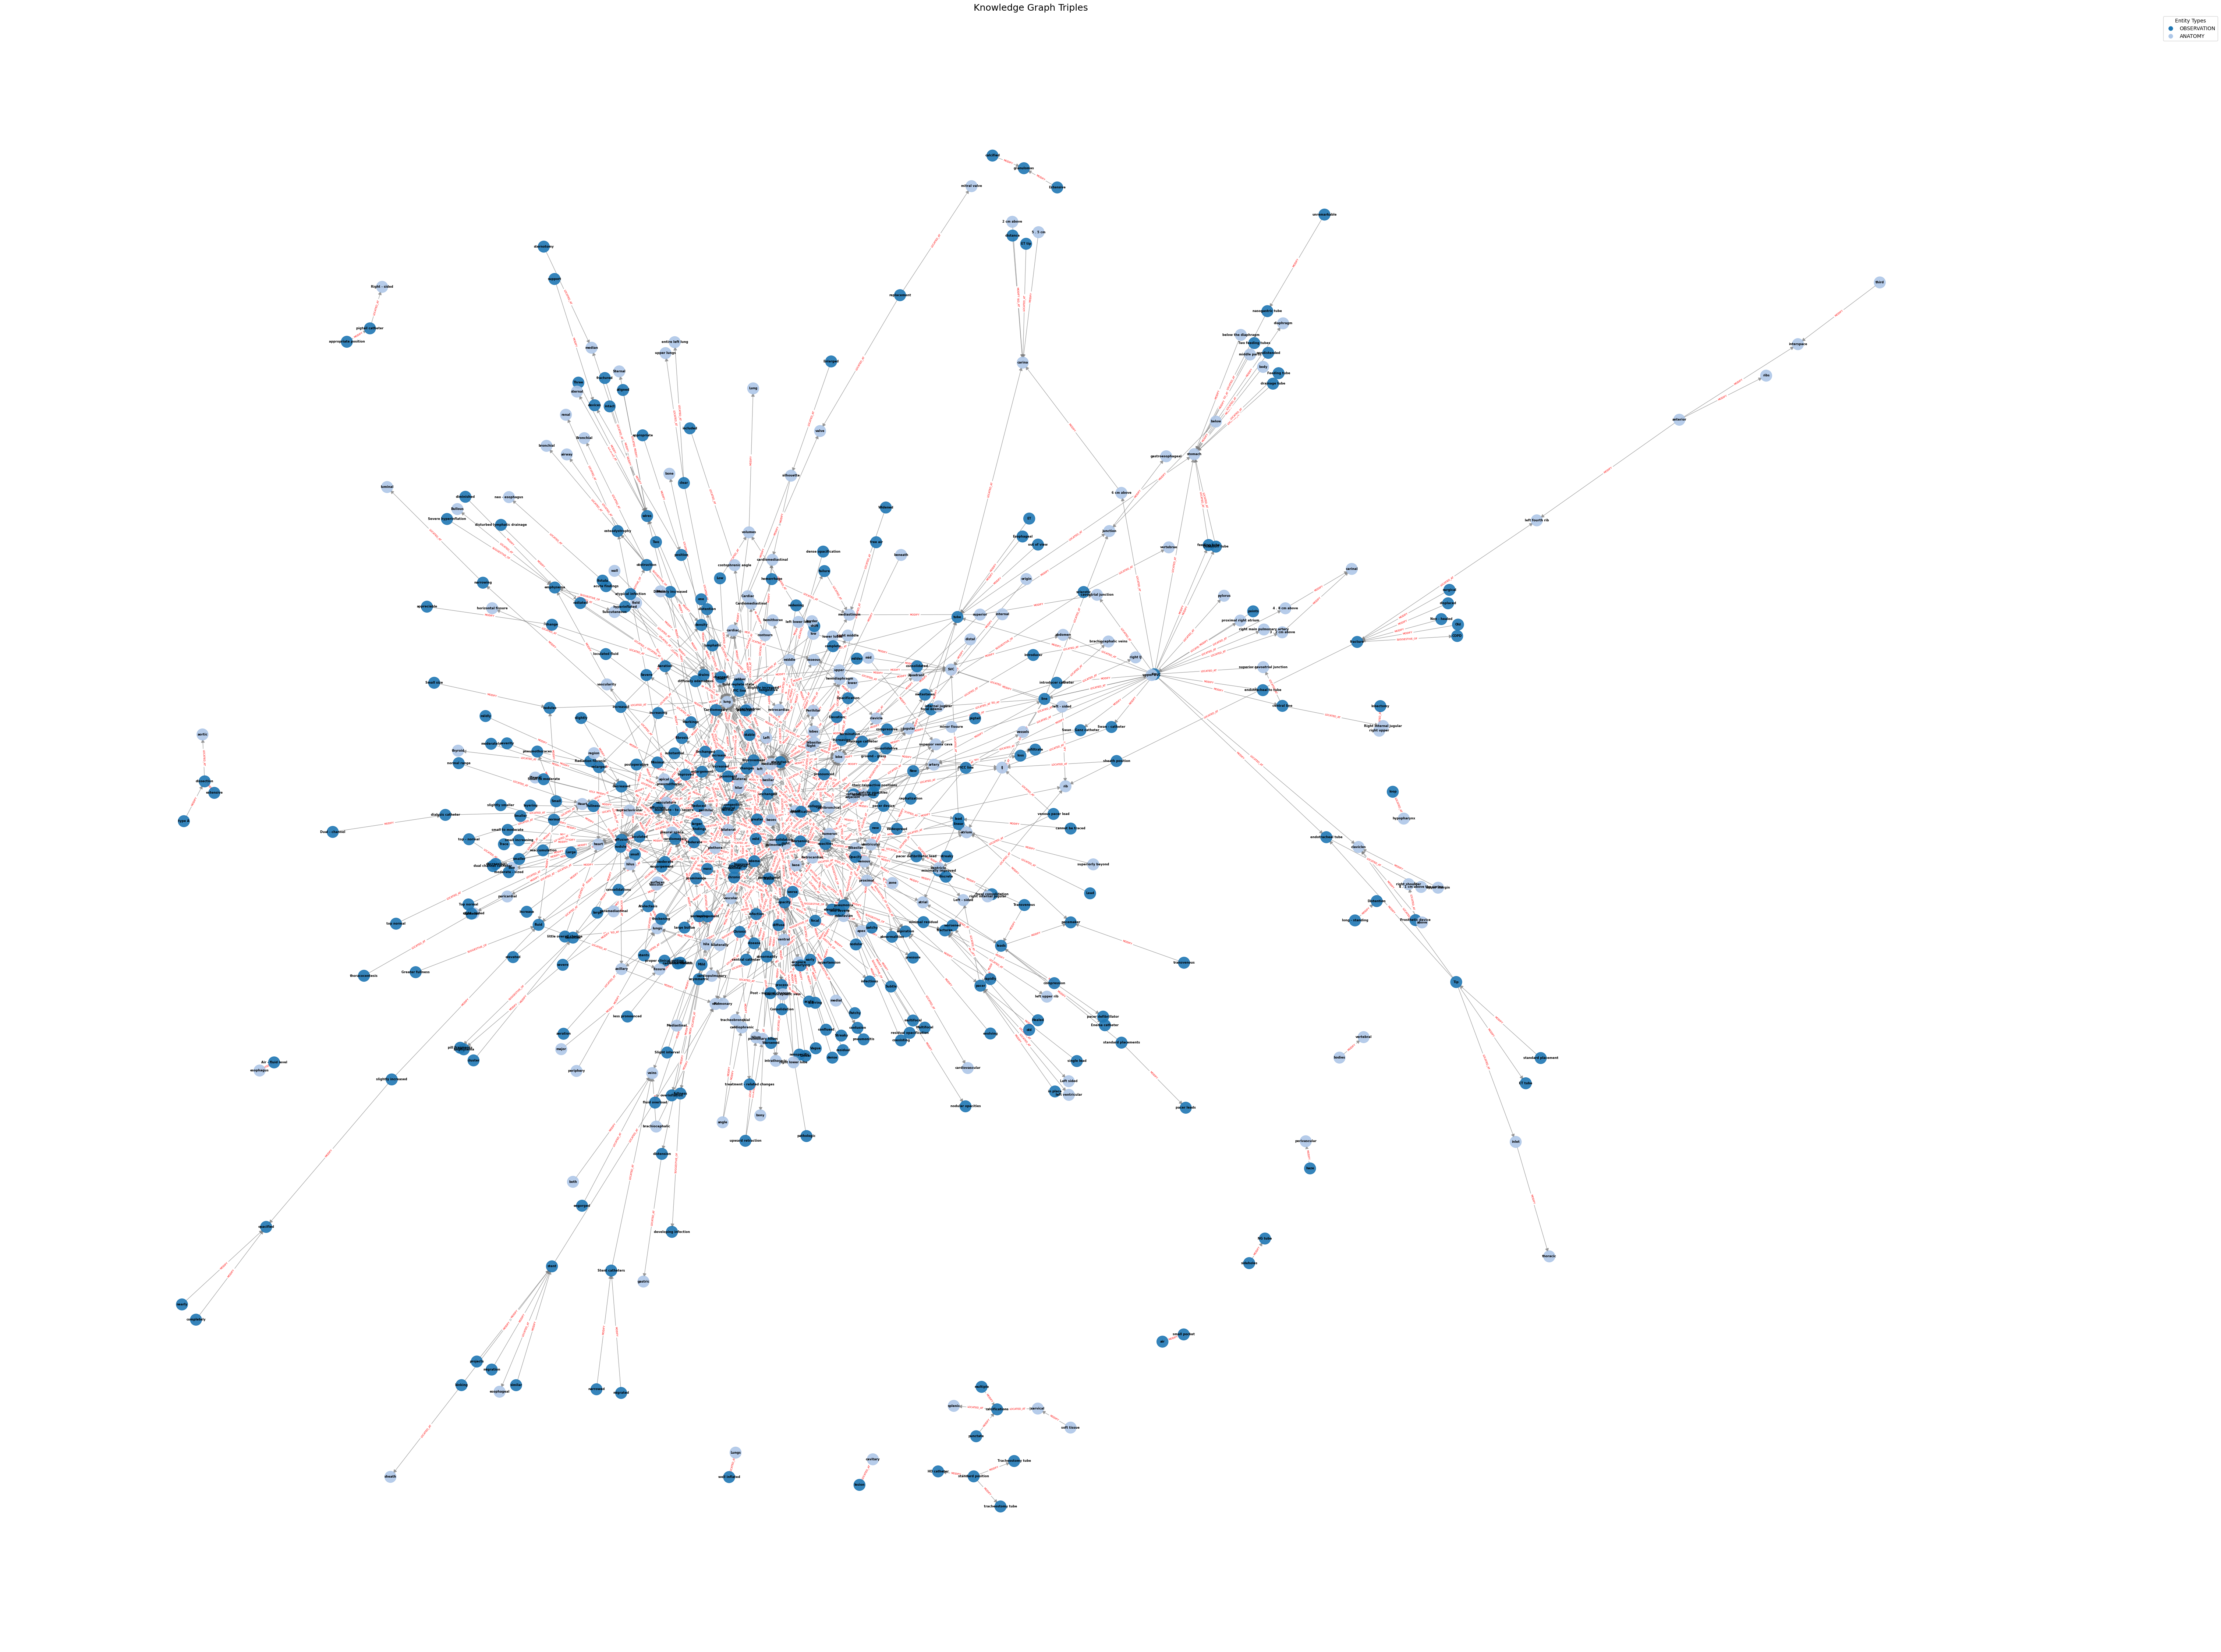

In [27]:
# Define colors for different entity types
# Using a more robust type extraction from RadGraph's label format
def get_main_etype(etype_full):
    if '::' in etype_full:
        return etype_full.split('::')[0]
    return etype_full # fallback for simpler types

entity_types = [get_main_etype(G_sample.nodes[node]['etype']) for node in G_sample.nodes()]
unique_entity_types = list(set(entity_types))

# Assign a distinct color to each unique entity type
colors = plt.colormaps.get_cmap('tab20') # Updated line to address DeprecationWarning
color_map = {etype: colors(i) for i, etype in enumerate(unique_entity_types)}

node_colors = [color_map[get_main_etype(G_sample.nodes[node]['etype'])] for node in G_sample.nodes()]
node_labels = {node: G_sample.nodes[node]['label'] for node in G_sample.nodes()}
edge_labels = nx.get_edge_attributes(G_sample, 'label')

plt.figure(figsize=(60, 45)) # Adjust figure size for better visibility

# Use a layout algorithm for positioning nodes (e.g., spring_layout for aesthetic placement)
pos = nx.spring_layout(G_sample, k=0.8, iterations=50)

# Draw nodes (reduced node size)
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=500, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G_sample, pos, width=1.0, alpha=0.7, edge_color='gray', arrowsize=15) # Slightly reduced width and arrowsize

# Draw node labels
nx.draw_networkx_labels(G_sample, pos, labels=node_labels, font_size=6, font_weight='bold')

# Draw edge labels
nx.draw_networkx_edge_labels(G_sample, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Create a legend for entity types
legend_handles = []
for etype, color in color_map.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=etype,
                                       markerfacecolor=color, markersize=10))
plt.legend(handles=legend_handles, title="Entity Types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Knowledge Graph Triples', size=18) # Slightly increased title size
plt.axis('off') # Hide the axes
plt.tight_layout()
plt.show()


## 3) Map extracted mentions → UMLS CUIs (Entity Disambiguation)


In [28]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [29]:
MRCONSO = f"/content/drive/MyDrive/MRCONSO.RRF"
print("MRCONSO exists:", os.path.exists(MRCONSO))


MRCONSO exists: True


In [37]:
# Flatten entity mentions across batch
all_entity_mentions = []
for ents in all_entities:
    for _, e in ents.items():
        all_entity_mentions.append(e.text)

print("Total entity mentions (batch):", len(all_entity_mentions))
print("Sample mentions:", all_entity_mentions[:10])

Total entity mentions (batch): 2903
Sample mentions: ['chronic', 'interstitial', 'lung', 'disease', 'superimposed process', 'Air - fluid level', 'esophagus', 'CREST syndrome', 'cluster', 'small']


In [46]:
import re
from collections import defaultdict

# --- Base normalize (keep close to your original) ---
def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9\s\-]", "", s)  # keep hyphen
    return s

# --- Canonical surface form (still deterministic exact matching) ---
def canonicalize_surface(s: str) -> str:
    s = s.lower().strip()
    s = re.sub(r"[-/]", " ", s)          # unify hyphen/slash
    s = re.sub(r"[^a-z0-9\s]", " ", s)   # drop punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

# --- Measurement detector (exclude from mapping denominator) ---
MEAS_RE = re.compile(r"\b\d+(\.\d+)?\s*(mm|cm|m)\b")
def is_measurement_like(s: str) -> bool:
    return bool(MEAS_RE.search(s))

# --- Deterministic head candidates ---
STOP = {"no","not","without","with","of","in","on","at","the","a","an","and","or","to","for"}
LATERAL = {"left","right","bilateral","bl","b","l","r"}
SEVERITY = {"mild","mildly","moderate","moderately","severe","marked","slight","small","tiny","minimal","possible","likely"}

def head_candidates(m_norm_or_can: str):
    toks = [t for t in m_norm_or_can.split() if t and (t not in STOP)]
    toks = [t for t in toks if t not in LATERAL and t not in SEVERITY]
    cands = []
    if len(toks) >= 1: cands.append(toks[-1])
    if len(toks) >= 2: cands.append(" ".join(toks[-2:]))
    if len(toks) >= 3: cands.append(" ".join(toks[-3:]))
    # unique, longest first
    return sorted(set(cands), key=lambda x: (-len(x.split()), x))

# ---- Extract mention strings from ALL extracted entities ----
mentions_raw = []
mention_to_types = defaultdict(set)  # mention_norm -> set(types)

for ents in all_entities:
    for e in ents.values():
        if e.text and e.text.strip():
            t = e.text.strip()
            mentions_raw.append(t)
            mention_to_types[normalize_text(t)].add(e.etype)

mentions_norm = [normalize_text(m) for m in mentions_raw if normalize_text(m)]
unique_mentions = sorted(set(mentions_norm))

print("Total mentions:", len(mentions_raw))
print("Unique normalized mentions:", len(unique_mentions))
print("Sample:", unique_mentions[:20])

# ---- Build mapping keys per mention (full + canonical + head fallback) ----
mention_keys = {}   # mention_norm -> dict with keys + meta
key_to_mentions = defaultdict(list)  # key_string -> list[(mention_norm, match_type)]

for m in unique_mentions:
    m_can = canonicalize_surface(m)
    meas = is_measurement_like(m_can)

    keys = []
    # Full forms
    keys.append(("full_norm", m))
    if m_can and m_can != m:
        keys.append(("full_can", m_can))

    # Head fallbacks from canonical (more stable)
    for hc in head_candidates(m_can):
        keys.append(("head", hc))

    # De-dup keys but preserve priority order
    seen = set()
    keys_unique = []
    for ktype, k in keys:
        if k and k not in seen:
            keys_unique.append((ktype, k))
            seen.add(k)

    mention_keys[m] = {
        "canonical": m_can,
        "is_measurement": meas,
        "keys": keys_unique,   # ordered list
        "types_seen": sorted(list(mention_to_types.get(m, set()))),
    }

    for ktype, k in keys_unique:
        key_to_mentions[k].append((m, ktype))

print("Avg keys/mention:", sum(len(v["keys"]) for v in mention_keys.values()) / max(1, len(mention_keys)))
print("Measurement-like mentions:", sum(1 for v in mention_keys.values() if v["is_measurement"]))


Total mentions: 2903
Unique normalized mentions: 581
Sample: ['2 cm above', '3  2 cm above', '4  1 cm above the carina', '4  8 cm above', '5  5 cm', '6 cm above', 'abdomen', 'abnormalities', 'abnormality', 'above', 'acute', 'acute disease', 'acute findings', 'adjacent', 'aeration', 'air', 'air - fluid level', 'airspace', 'airway', 'aligned']
Avg keys/mention: 1.4371772805507745
Measurement-like mentions: 6


In [47]:
from collections import defaultdict

alias_to_candidates = defaultdict(list)  # mention_norm -> candidates (from any key)
match_trace = defaultdict(list)          # mention_norm -> list of {key, key_type, cui, sab, tty, ispref}
seen_pairs = set()
kept_rows = 0

with open(MRCONSO, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        parts = line.rstrip("\n").split("|")
        if len(parts) < 15:
            continue

        cui = parts[0]
        lat = parts[1]
        ispref = parts[6]
        sab = parts[11]
        tty = parts[12]
        s = parts[14]

        if lat != "ENG":
            continue

        # IMPORTANT: use canonical surface for MRCONSO STR too
        s_key = canonicalize_surface(s)
        if s_key not in key_to_mentions:
            continue

        # This MRCONSO string matches at least one of our keys
        for mention_norm, ktype in key_to_mentions[s_key]:
            # Optional: don't even try mapping measurement mentions
            if mention_keys[mention_norm]["is_measurement"]:
                continue

            # Deduplicate (mention, cui, sab, tty)
            key = (mention_norm, cui, sab, tty)
            if key in seen_pairs:
                continue
            seen_pairs.add(key)

            cand = {
                "cui": cui,
                "sab": sab,
                "tty": tty,
                "ispref": ispref,
                "str": s,
                "matched_key": s_key,
                "matched_key_type": ktype,
            }
            alias_to_candidates[mention_norm].append(cand)
            match_trace[mention_norm].append(cand)
            kept_rows += 1

print("Exact matches found in MRCONSO rows:", kept_rows)
print("Mentions with >=1 candidate:", sum(1 for m in unique_mentions if m in alias_to_candidates), "/", len(unique_mentions))
print("Mentions eligible (non-measurement):", sum(1 for m in unique_mentions if not mention_keys[m]["is_measurement"]))


Exact matches found in MRCONSO rows: 5594
Mentions with >=1 candidate: 510 / 581
Mentions eligible (non-measurement): 575


In [48]:
TOP_K = 5
USE_MRSTY_FILTER = False
SAB_PREFERENCE = ["SNOMEDCT_US", "RXNORM", "MSH"]  # or None

KEYTYPE_PRIORITY = {"full_norm": 0, "full_can": 1, "head": 2}

def rank_candidate(c):
    # 0) Prefer direct/full matches over head fallback
    ktype_rank = KEYTYPE_PRIORITY.get(c.get("matched_key_type", "head"), 9)

    # 1) Preferred term in source
    ispref_rank = 0 if c.get("ispref") == "Y" else 1

    # 2) Prefer certain SABs (optional)
    sab_rank = 999
    if SAB_PREFERENCE is not None:
        sab = c.get("sab")
        if sab in SAB_PREFERENCE:
            sab_rank = SAB_PREFERENCE.index(sab)
    else:
        sab_rank = 0

    # 3) Mild TTY preference
    tty = c.get("tty", "")
    tty_rank = 0 if tty in {"PT", "PN", "HT", "MH"} else 1

    # 4) Stable tie-breakers
    return (ktype_rank, ispref_rank, sab_rank, tty_rank, c.get("sab", ""), c.get("tty", ""), c.get("cui", ""))

def apply_mrsty_filter(cui: str, target: str) -> bool:
    if not USE_MRSTY_FILTER:
        return True
    tuis = cui_to_tuis.get(cui, set())
    if target == "ANATOMY":
        return len(tuis & ANATOMY_TUIS) > 0
    if target == "OBSERVATION":
        return len(tuis & OBSERVATION_TUIS) > 0
    return True

mention2cui = {}

for m in unique_mentions:
    # measurements are excluded deterministically
    if mention_keys[m]["is_measurement"]:
        mention2cui[m] = {
            "best_cui": None,
            "candidates": [],
            "types_seen": mention_keys[m]["types_seen"],
            "excluded_reason": "measurement_like",
        }
        continue

    cands = alias_to_candidates.get(m, [])
    types_here = mention_keys[m]["types_seen"]

    filtered = []
    for c in cands:
        cui = c["cui"]
        ok = True
        if types_here:
            ok = any(apply_mrsty_filter(cui, t) for t in types_here)
        if ok:
            filtered.append(c)

    filtered.sort(key=rank_candidate)
    top = filtered[:TOP_K]
    best = top[0]["cui"] if top else None

    mention2cui[m] = {
        "best_cui": best,
        "candidates": top,
        "types_seen": types_here,
        "excluded_reason": None,
    }

eligible = sum(1 for m in unique_mentions if not mention_keys[m]["is_measurement"])
mapped = sum(1 for m, v in mention2cui.items() if (not mention_keys[m]["is_measurement"]) and (v["best_cui"] is not None))

print("Mapped (eligible only):", mapped, "/", eligible)
print("Mapped (including measurements):", sum(1 for v in mention2cui.values() if v["best_cui"] is not None), "/", len(mention2cui))
print("Example mapped:", next((k, v) for k, v in mention2cui.items() if v["best_cui"] is not None))


Mapped (eligible only): 510 / 575
Mapped (including measurements): 510 / 581
Example mapped: ('abdomen', {'best_cui': 'C1281594', 'candidates': [{'cui': 'C1281594', 'sab': 'SNOMEDCT_US', 'tty': 'IS', 'ispref': 'Y', 'str': 'Abdomen', 'matched_key': 'abdomen', 'matched_key_type': 'full_norm'}, {'cui': 'C1508499', 'sab': 'SNOMEDCT_US', 'tty': 'OAP', 'ispref': 'Y', 'str': 'Abdomen', 'matched_key': 'abdomen', 'matched_key_type': 'full_norm'}, {'cui': 'C0000726', 'sab': 'CHV', 'tty': 'PT', 'ispref': 'Y', 'str': 'abdomen', 'matched_key': 'abdomen', 'matched_key_type': 'full_norm'}, {'cui': 'C0000726', 'sab': 'MTH', 'tty': 'PN', 'ispref': 'Y', 'str': 'Abdomen', 'matched_key': 'abdomen', 'matched_key_type': 'full_norm'}, {'cui': 'C0230168', 'sab': 'NCI', 'tty': 'PT', 'ispref': 'Y', 'str': 'Abdomen', 'matched_key': 'abdomen', 'matched_key_type': 'full_norm'}], 'types_seen': ['ANATOMY::DEFINITELY PRESENT'], 'excluded_reason': None})


In [57]:
entities_with_cui_per_report = []

for ents in all_entities:
    enriched = {}
    for ent_id, ent in ents.items():
        m = normalize_text(ent.text)
        info = mention2cui.get(m, {"best_cui": None, "candidates": [], "types_seen": []})
        enriched[ent_id] = {
            "text": ent.text,
            "etype": ent.etype,
            "start": ent.start,
            "end": ent.end,
            "cui": info["best_cui"],
            "cui_candidates": info["candidates"],  # list of dicts (cui, sab, tty, ispref, str)
        }
    entities_with_cui_per_report.append(enriched)

print("Enriched entities for report[0]:", len(entities_with_cui_per_report[0]))
print("Sample entity:", list(entities_with_cui_per_report[0].items())[:1])


Enriched entities for report[0]: 15
Sample entity: [('1', {'text': 'chronic', 'etype': 'OBSERVATION::DEFINITELY PRESENT', 'start': 5, 'end': 5, 'cui': 'C0205191', 'cui_candidates': [{'cui': 'C0205191', 'sab': 'SNOMEDCT_US', 'tty': 'PT', 'ispref': 'Y', 'str': 'Chronic', 'matched_key': 'chronic', 'matched_key_type': 'full_norm'}, {'cui': 'C1547296', 'sab': 'HL7V2.5', 'tty': 'PT', 'ispref': 'Y', 'str': 'Chronic', 'matched_key': 'chronic', 'matched_key_type': 'full_norm'}, {'cui': 'C1555457', 'sab': 'HL7V3.0', 'tty': 'PT', 'ispref': 'Y', 'str': 'Chronic', 'matched_key': 'chronic', 'matched_key_type': 'full_norm'}, {'cui': 'C0205191', 'sab': 'MTH', 'tty': 'PN', 'ispref': 'Y', 'str': 'chronic', 'matched_key': 'chronic', 'matched_key_type': 'full_norm'}, {'cui': 'C0205191', 'sab': 'DXP', 'tty': 'FI', 'ispref': 'Y', 'str': 'CHRONIC', 'matched_key': 'chronic', 'matched_key_type': 'full_norm'}]})]


In [58]:
coverage = []
for m, info in mention2cui.items():
    cands = info.get("candidates", [])
    coverage.append({
        "mention": m,
        "canonical": mention_keys[m]["canonical"],
        "types_seen": ",".join(info.get("types_seen", [])),
        "is_measurement": mention_keys[m]["is_measurement"],
        "excluded_reason": info.get("excluded_reason"),
        "mapped": info["best_cui"] is not None,
        "best_cui": info["best_cui"],
        "num_candidates": len(cands),
        "top_sab": (cands[0]["sab"] if cands else None),
        "top_tty": (cands[0]["tty"] if cands else None),
        "top_match_type": (cands[0].get("matched_key_type") if cands else None),
        "top_matched_key": (cands[0].get("matched_key") if cands else None),
    })

df_cov = pd.DataFrame(coverage)

print("Coverage summary (all mentions):")
print(df_cov["mapped"].value_counts(dropna=False))

print("\nCoverage summary (eligible only, i.e., excluding measurement-like):")
eligible_df = df_cov[df_cov["is_measurement"] == False]
print(eligible_df["mapped"].value_counts(dropna=False))




Coverage summary (all mentions):
mapped
True     510
False     71
Name: count, dtype: int64

Coverage summary (eligible only, i.e., excluding measurement-like):
mapped
True     510
False     65
Name: count, dtype: int64


In [59]:
display(df_cov.head(30))

mention                canonical  \
0                 2 cm above               2 cm above   
1              3  2 cm above             3 2 cm above   
2   4  1 cm above the carina  4 1 cm above the carina   
3              4  8 cm above             4 8 cm above   
4                    5  5 cm                   5 5 cm   
5                 6 cm above               6 cm above   
6                    abdomen                  abdomen   
7              abnormalities            abnormalities   
8                abnormality              abnormality   
9                      above                    above   
10                     acute                    acute   
11             acute disease            acute disease   
12            acute findings           acute findings   
13                  adjacent                 adjacent   
14                  aeration                 aeration   
15                       air                      air   
16         air - fluid level          air fluid level   
17                  airspace                 airspace   
18                    airway                   airway   
19                   aligned                  aligned   
20                 alignment                alignment   
21                     angle                    angle   
22                  anterior                 anterior   
23                    aortic                   aortic   
24                      apex                     apex   
25                    apical                   apical   
26               appreciable              appreciable   
27               appropriate              appropriate   
28      appropriate position     appropriate position   
29                    artery                   artery   

                                           types_seen  is_measurement  \
0            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
1            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
2            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
3            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
4            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
5            ANATOMY::MEASUREMENT::DEFINITELY PRESENT            True   
6                         ANATOMY::DEFINITELY PRESENT           False   
7                      OBSERVATION::DEFINITELY ABSENT           False   
8   OBSERVATION::DEFINITELY ABSENT,OBSERVATION::DE...           False   
9                         ANATOMY::DEFINITELY PRESENT           False   
10                     OBSERVATION::DEFINITELY ABSENT           False   
11                     OBSERVATION::DEFINITELY ABSENT           False   
12                     OBSERVATION::DEFINITELY ABSENT           False   
13  ANATOMY::DEFINITELY PRESENT,OBSERVATION::DEFIN...           False   
14                    OBSERVATION::DEFINITELY PRESENT           False   
15                    OBSERVATION::DEFINITELY PRESENT           False   
16                    OBSERVATION::DEFINITELY PRESENT           False   
17                        ANATOMY::DEFINITELY PRESENT           False   
18                        ANATOMY::DEFINITELY PRESENT           False   
19                    OBSERVATION::DEFINITELY PRESENT           False   
20                    OBSERVATION::DEFINITELY PRESENT           False   
21                        ANATOMY::DEFINITELY PRESENT           False   
22                        ANATOMY::DEFINITELY PRESENT           False   
23                        ANATOMY::DEFINITELY PRESENT           False   
24                        ANATOMY::DEFINITELY PRESENT           False   
25                        ANATOMY::DEFINITELY PRESENT           False   
26                     OBSERVATION::DEFINITELY ABSENT           False   
27                    OBSERVATION::DEFINITELY PRESENT           False   
28                    OBSERVATION::DEFINITELY PRESENT           False   
29                        ANATOMY::DEFINITELY PRESENT          

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [60]:
eligible_df = eligible_df.drop(columns=["is_measurement", "excluded_reason"])


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
eligible_df.head(30)

mention             canonical  \
6                abdomen               abdomen   
7          abnormalities         abnormalities   
8            abnormality           abnormality   
9                  above                 above   
10                 acute                 acute   
11         acute disease         acute disease   
12        acute findings        acute findings   
13              adjacent              adjacent   
14              aeration              aeration   
15                   air                   air   
16     air - fluid level       air fluid level   
17              airspace              airspace   
18                airway                airway   
19               aligned               aligned   
20             alignment             alignment   
21                 angle                 angle   
22              anterior              anterior   
23                aortic                aortic   
24                  apex                  apex   
25                apical                apical   
26           appreciable           appreciable   
27           appropriate           appropriate   
28  appropriate position  appropriate position   
29                artery                artery   
30            aspiration            aspiration   
31  aspiration pneumonia  aspiration pneumonia   
32            asymmetric            asymmetric   
33           atelectasis           atelectasis   
34           atelectatic           atelectatic   
35                atrial                atrial   

                                           types_seen  mapped  best_cui  \
6                         ANATOMY::DEFINITELY PRESENT    True  C1281594   
7                      OBSERVATION::DEFINITELY ABSENT    True  C0000769   
8   OBSERVATION::DEFINITELY ABSENT,OBSERVATION::DE...    True  C1704258   
9                         ANATOMY::DEFINITELY PRESENT    True  C1282910   
10                     OBSERVATION::DEFINITELY ABSENT    True  C1547229   
11                     OBSERVATION::DEFINITELY ABSENT    True  C0001314   
12                     OBSERVATION::DEFINITELY ABSENT    True  C2607943   
13  ANATOMY::DEFINITELY PRESENT,OBSERVATION::DEFIN...    True  C0205117   
14                    OBSERVATION::DEFINITELY PRESENT    True  C2215609   
15                    OBSERVATION::DEFINITELY PRESENT    True  C0001861   
16                    OBSERVATION::DEFINITELY PRESENT    True  C0740844   
17                        ANATOMY::DEFINITELY PRESENT   False      None   
18                        ANATOMY::DEFINITELY PRESENT    True  C0458827   
19                    OBSERVATION::DEFINITELY PRESENT    True  C1706765   
20                    OBSERVATION::DEFINITELY PRESENT    True  C1706765   
21                        ANATOMY::DEFINITELY PRESENT    True  C0205143   
22                        ANATOMY::DEFINITELY PRESENT    True  C0205094   
23                        ANATOMY::DEFINITELY PRESENT    True  C0003483   
24                        ANATOMY::DEFINITELY PRESENT    True  C3890171   
25                        ANATOMY::DEFINITELY PRESENT    True  C0205111   
26                     OBSERVATION::DEFINITELY ABSENT   False      None   
27                    OBSERVATION::DEFINITELY PRESENT    True  C1548787   
28                    OBSERVATION::DEFINITELY PRESENT    True  C0733755   
29                        ANATOMY::DEFINITELY PRESENT    True  C0003842   
30                             OBSERVATION::UNCERTAIN    True  C0349707   
31  OBSERVATION::DEFINITELY PRESENT,OBSERVATION::U...    True  C0032290   
32                    OBSERVATION::DEFINITELY PRESENT    True  C0332514   
33  OBSERVATION::DEFINITELY ABSENT,OBSERVATION::DE...    True  C0004144   
34                    OBSERVATION::DEFINITELY PRESENT    True  C0439688   
35                        ANATOMY::DEFINITELY PRESENT    True  C0018792   

    num_candidates      top_sab top_tty top_match_type       top_matched_key  
6                5  SNOMEDCT_US      IS      full_norm       

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



## 6) Export



```entities_with_cui_per_report```

```mention2cui```

```cui_coverage.csv```




In [ ]:
import pickle, os

out_path = "/content/drive/MyDrive/hybrid_kg/entities_with_cui.pkl"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "wb") as f:
    pickle.dump(entities_with_cui_per_report, f)

print("Saved:", out_path)


In [ ]:
with open("/content/drive/MyDrive/hybrid_kg/mention2cui.pkl", "wb") as f:
    pickle.dump(mention2cui, f)


In [ ]:
df_cov.to_csv("/content/drive/MyDrive/hybrid_kg/cui_coverage.csv", index=False)
